In [62]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

In [7]:
sample_files = ["e1e9848971fc26a947f63de394ec4f916f36bc933441b31310b14826e5287ca4",
                "84dd74de2427a199404006e646eae54245a24d742a4b2b9bc6f22cf0f3584ea9",
                "d5ae016998b714d6f2b5263fb014d587341a92758dd8d5113d08bb20ffdfffb2",
                "e6f5aa1cfd6e746e758425421a305b339447df37afe6d938192efa4188e009a5",
                "f03f52f854fcd3d6651873ca92e95df90feaeb34dcc64982dbcb5907dfdedee1"]

In [56]:
file_dlls = []
func_dlls = []
file_funcs = []
files = []
funcs = []
dlls = []
with open('../edge_lists/bin_dll_func.csv') as file:
    for line in file:
        line_split = line.split(",")
        if len(line_split) == 4 and line_split[3] == ' "NAME"\n':
            line_split = [x.strip() for x in line_split]
            line_split = [x.strip('"') for x in line_split]
            
            if len(files) < 20:
                file_dlls.append((line_split[0], line_split[1]))
                func_dlls.append((line_split[1], line_split[2]))
                file_funcs.append((line_split[0], line_split[2]))
                
                if line_split[0] not in files:
                    files.append(line_split[0])
                    
                if line_split[1] not in dlls:
                    dlls.append(line_split[1])
                    
                if line_split[2] not in funcs:
                    funcs.append(line_split[2])

In [57]:
file_dlls = list(set(file_dlls))
func_dlls = list(set(func_dlls))
file_funcs = list(set(file_funcs))

In [77]:
arthrograph = nx.Graph()

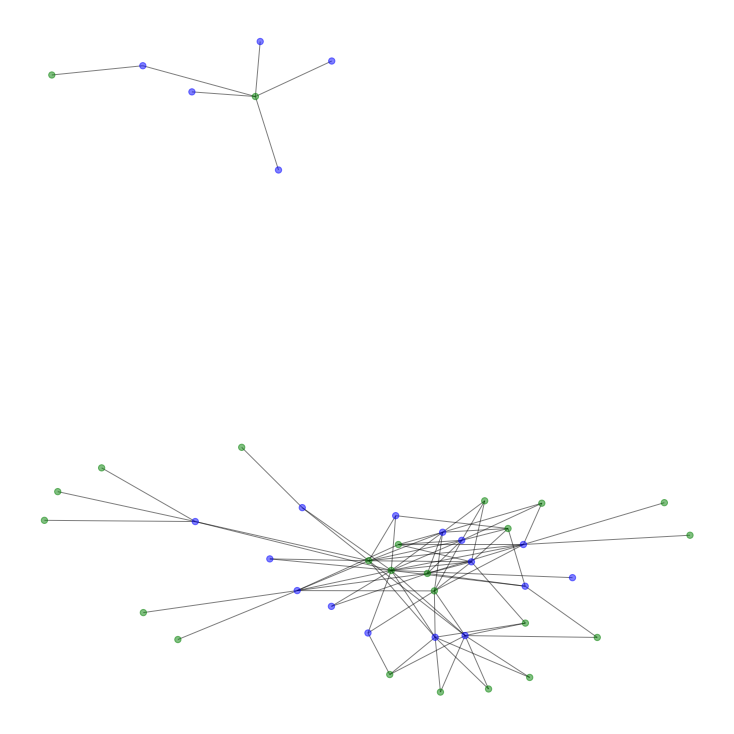

In [78]:
arthrograph.add_edges_from(file_dlls)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(arthrograph, node_color = color_map,with_labels = False, node_size=40, alpha = 0.5)

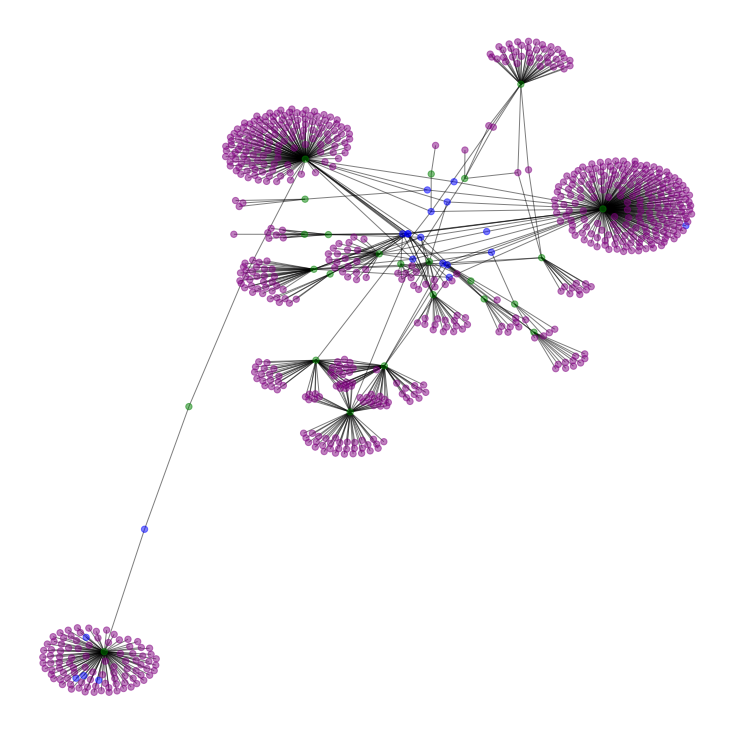

In [79]:
arthrograph.add_edges_from(func_dlls)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    elif node in dlls: 
        color_map.append('green')
    else:
        color_map.append('purple')

nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

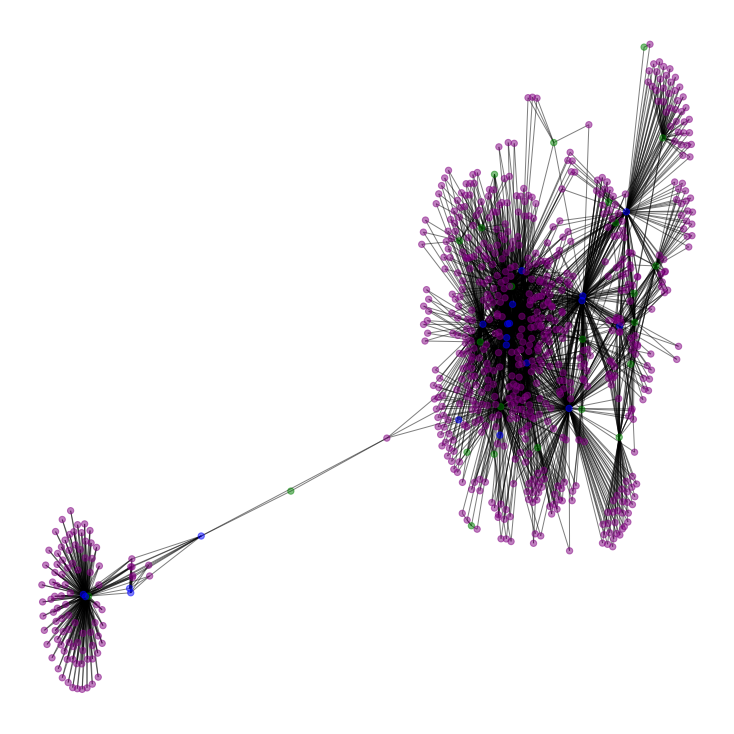

In [80]:
arthrograph.add_edges_from(file_funcs)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    elif node in dlls: 
        color_map.append('green')
    else:
        color_map.append('purple')

nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)